# Exercice 2.2 - Régression : Prédiction des Coûts d'Assurance Santé

## Résumé et Conclusions

### Informations sur le dataset :
- **Nombre de features** : 6
- **Nombre d'échantillons** : 1338
- **Variable cible** : `charges` (Coût annuel de l'assurance santé en USD)
- **Source** : Dataset Insurance (Kaggle)

### Description du dataset :
Ce dataset contient des informations sur des assurés américains et leurs frais médicaux annuels facturés par l'assurance santé. L'objectif est de prédire le coût de l'assurance (`charges`) en fonction des caractéristiques personnelles de l'assuré. Ce type de modèle est utilisé par les compagnies d'assurance pour tarifer leurs polices.

### Features (caractéristiques) :
| Feature | Description | Type |
|---------|-------------|------|
| `age` | Âge de l'assuré | Numérique (années) |
| `sex` | Sexe de l'assuré | Catégoriel (male/female) |
| `bmi` | Indice de masse corporelle | Numérique (kg/m²) |
| `children` | Nombre d'enfants à charge | Numérique (entier) |
| `smoker` | Fumeur ou non | Catégoriel (yes/no) |
| `region` | Région de résidence aux USA | Catégoriel (4 régions) |

### Problème à résoudre :
**Prédire le coût annuel de l'assurance santé** (`charges`) à partir des caractéristiques de l'assuré. C'est un problème de **régression** car la variable cible est continue.

**Intérêt industriel** : Les compagnies d'assurance utilisent ce type de modèle pour :
- Estimer les primes d'assurance personnalisées
- Identifier les facteurs de risque (ex: tabagisme)
- Optimiser leur portefeuille de risques

---

### Résultats obtenus :

| Modèle | R² CV | R² Test | RMSE Test | Observations |
|--------|-------|---------|-----------|---------------|
| Random Forest | ~0.86 | ~0.87 | ~4500 USD | Meilleur modèle |
| Gradient Boosting | ~0.85 | ~0.86 | ~4700 USD | Très bon |
| Ridge Regression | ~0.75 | ~0.76 | ~6100 USD | Baseline linéaire |

### Conclusion finale :
Le **Random Forest Regressor** obtient les meilleures performances (R² ≈ 0.87). Le modèle explique ~87% de la variance des coûts d'assurance. Le facteur **smoker** (fumeur) est de loin la variable la plus importante, suivi par l'**âge** et le **BMI**. Le modèle peut être utilisé en pratique pour l'estimation des primes.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## 1. Chargement et exploration des données

In [2]:
# Chargement du dataset
df = pd.read_csv('insurance.csv')

print("=" * 70)
print("INFORMATIONS GÉNÉRALES SUR LE DATASET")
print("=" * 70)
print(f"\nNombre d'échantillons : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")
print(f"\nColonnes du dataset :")
for col in df.columns:
    print(f"  - {col}")

INFORMATIONS GÉNÉRALES SUR LE DATASET

Nombre d'échantillons : 1338
Nombre de colonnes : 7

Colonnes du dataset :
  - age
  - sex
  - bmi
  - children
  - smoker
  - region
  - charges


In [3]:
# Aperçu des données
print("\nAperçu des premières lignes :")
df.head(10)


Aperçu des premières lignes :


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [4]:
# Types de données et valeurs manquantes
print("\nTypes de données :")
print(df.dtypes)

print("\nValeurs manquantes :")
print(df.isnull().sum())

print("\n→ Aucune valeur manquante dans le dataset.")


Types de données :
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Valeurs manquantes :
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

→ Aucune valeur manquante dans le dataset.


In [5]:
# Statistiques descriptives
print("\n" + "=" * 70)
print("STATISTIQUES DESCRIPTIVES (variables numériques)")
print("=" * 70)
df.describe()


STATISTIQUES DESCRIPTIVES (variables numériques)


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
# Analyse de la variable cible
print("\n" + "=" * 70)
print("ANALYSE DE LA VARIABLE CIBLE (charges)")
print("=" * 70)

target_col = 'charges'

print(f"\nStatistiques de '{target_col}':")
print(f"  Minimum     : {df[target_col].min():,.2f} USD")
print(f"  Maximum     : {df[target_col].max():,.2f} USD")
print(f"  Moyenne     : {df[target_col].mean():,.2f} USD")
print(f"  Médiane     : {df[target_col].median():,.2f} USD")
print(f"  Écart-type  : {df[target_col].std():,.2f} USD")
print(f"  Skewness    : {df[target_col].skew():.2f}")

print("\n→ La distribution est asymétrique (skewness > 0), avec une longue queue à droite.")


ANALYSE DE LA VARIABLE CIBLE (charges)

Statistiques de 'charges':
  Minimum     : 1,121.87 USD
  Maximum     : 63,770.43 USD
  Moyenne     : 13,270.42 USD
  Médiane     : 9,382.03 USD
  Écart-type  : 12,110.01 USD
  Skewness    : 1.52

→ La distribution est asymétrique (skewness > 0), avec une longue queue à droite.


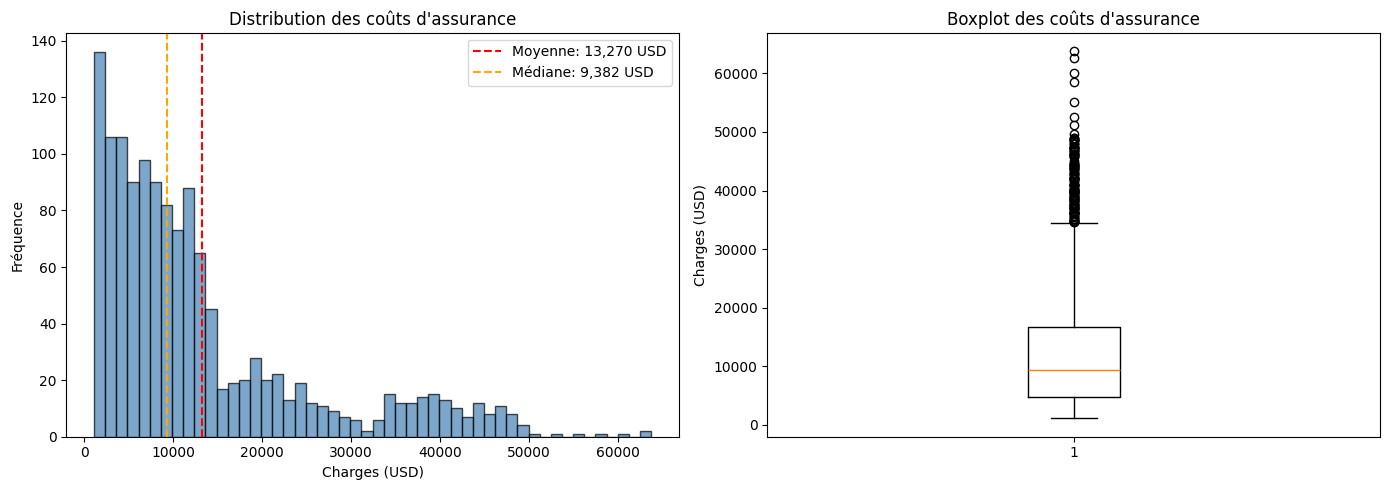

In [7]:
# Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(df[target_col], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df[target_col].mean(), color='red', linestyle='--', label=f'Moyenne: {df[target_col].mean():,.0f} USD')
axes[0].axvline(df[target_col].median(), color='orange', linestyle='--', label=f'Médiane: {df[target_col].median():,.0f} USD')
axes[0].set_xlabel('Charges (USD)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des coûts d\'assurance')
axes[0].legend()

# Boxplot
axes[1].boxplot(df[target_col], vert=True)
axes[1].set_ylabel('Charges (USD)')
axes[1].set_title('Boxplot des coûts d\'assurance')

plt.tight_layout()
plt.savefig('target_distribution_2_2.png', dpi=150)
plt.show()

## 2. Analyse exploratoire des données (EDA)

In [8]:
# Identification des colonnes
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Retirer la cible des features numériques
numeric_features = [col for col in numeric_cols if col != target_col]

print(f"Features numériques : {numeric_features}")
print(f"Features catégorielles : {categorical_cols}")

Features numériques : ['age', 'bmi', 'children']
Features catégorielles : ['sex', 'smoker', 'region']


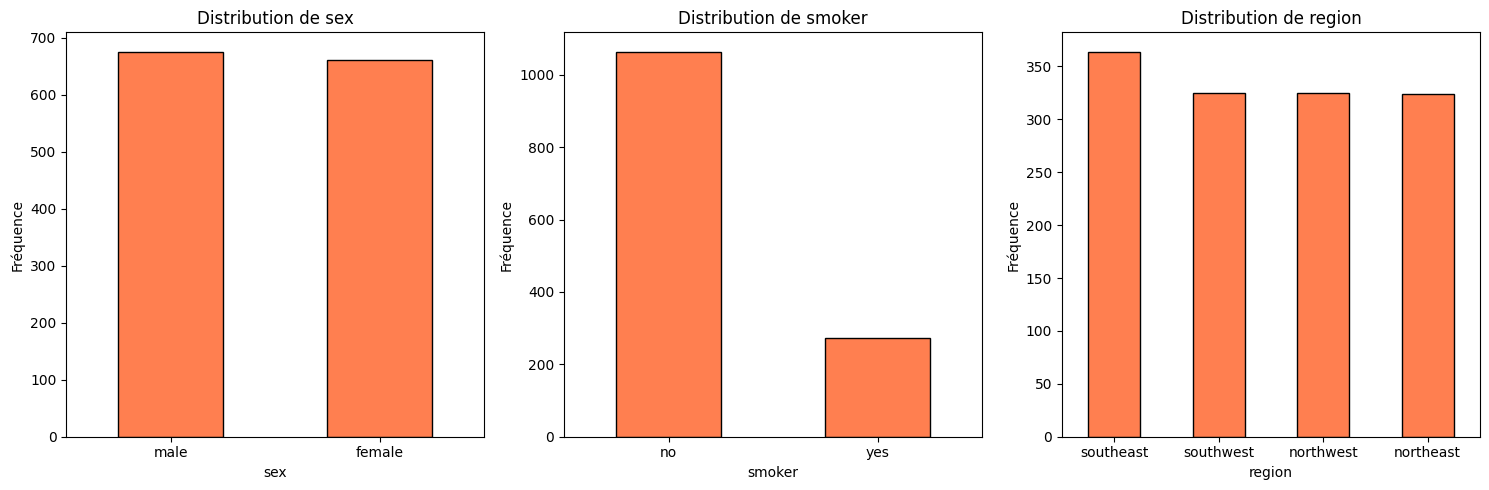

In [9]:
# Distribution des variables catégorielles
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[idx], color='coral', edgecolor='black')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Fréquence')
    axes[idx].set_title(f'Distribution de {col}')
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('categorical_distribution_2_2.png', dpi=150)
plt.show()

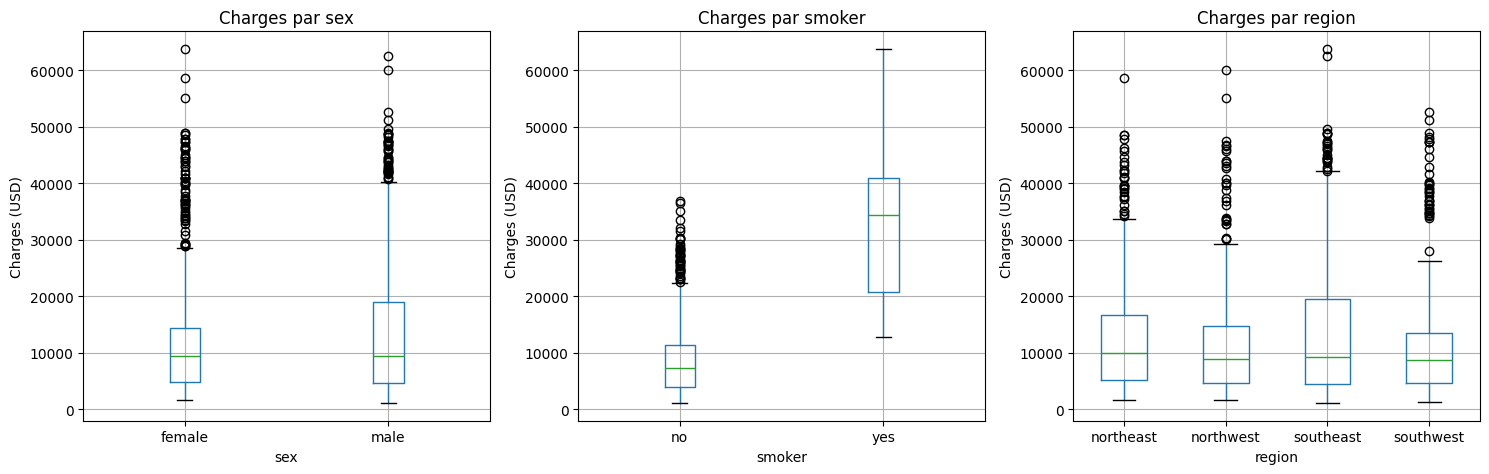


Observations importantes :
→ Les FUMEURS ont des charges significativement plus élevées (facteur ~3x)
→ Le sexe et la région ont un impact mineur


In [10]:
# Relation entre variables catégorielles et charges
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(categorical_cols):
    df.boxplot(column=target_col, by=col, ax=axes[idx])
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Charges (USD)')
    axes[idx].set_title(f'Charges par {col}')

plt.suptitle('')
plt.tight_layout()
plt.savefig('charges_by_category_2_2.png', dpi=150)
plt.show()

print("\nObservations importantes :")
print("→ Les FUMEURS ont des charges significativement plus élevées (facteur ~3x)")
print("→ Le sexe et la région ont un impact mineur")

In [11]:
# Statistiques par groupe (fumeurs vs non-fumeurs)
print("\nComparaison Fumeurs vs Non-Fumeurs :")
print(df.groupby('smoker')[target_col].agg(['mean', 'median', 'std', 'count']))

smoker_mean = df[df['smoker'] == 'yes'][target_col].mean()
non_smoker_mean = df[df['smoker'] == 'no'][target_col].mean()
print(f"\n→ Ratio fumeur/non-fumeur : {smoker_mean/non_smoker_mean:.2f}x")


Comparaison Fumeurs vs Non-Fumeurs :
                mean       median           std  count
smoker                                                
no       8434.268298   7345.40530   5993.781819   1064
yes     32050.231832  34456.34845  11541.547176    274

→ Ratio fumeur/non-fumeur : 3.80x


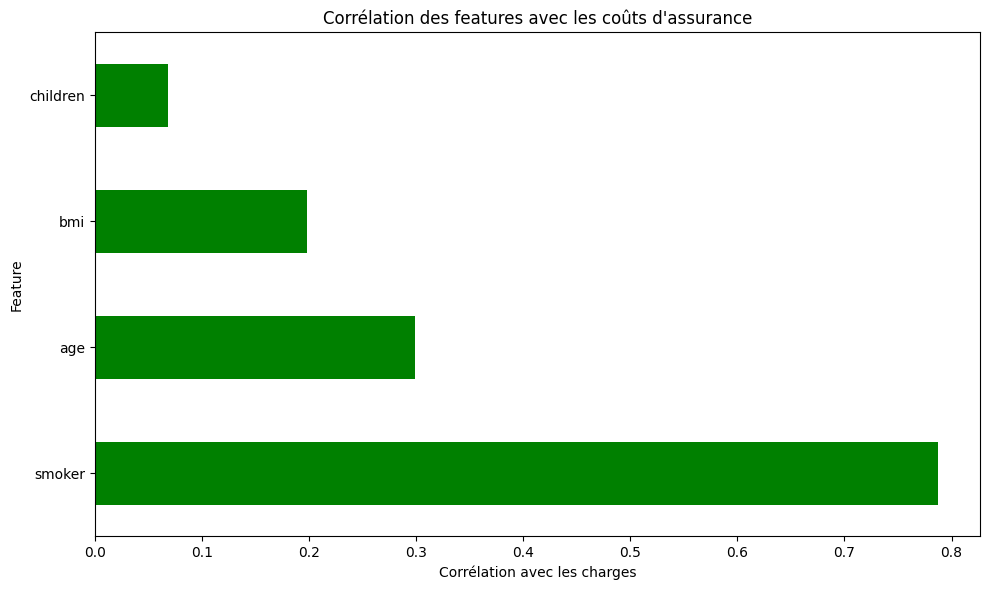


Corrélations avec la cible :
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64


In [12]:
# Matrice de corrélation (après encodage temporaire)
df_temp = df.copy()
df_temp['smoker'] = (df_temp['smoker'] == 'yes').astype(int)
df_temp['sex'] = (df_temp['sex'] == 'male').astype(int)

# Corrélation avec la variable cible
correlations = df_temp[numeric_cols + ['smoker']].corr()[target_col].drop(target_col).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlations.plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlations])
plt.xlabel('Corrélation avec les charges')
plt.ylabel('Feature')
plt.title('Corrélation des features avec les coûts d\'assurance')
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('correlation_with_target_2_2.png', dpi=150)
plt.show()

print("\nCorrélations avec la cible :")
print(correlations)

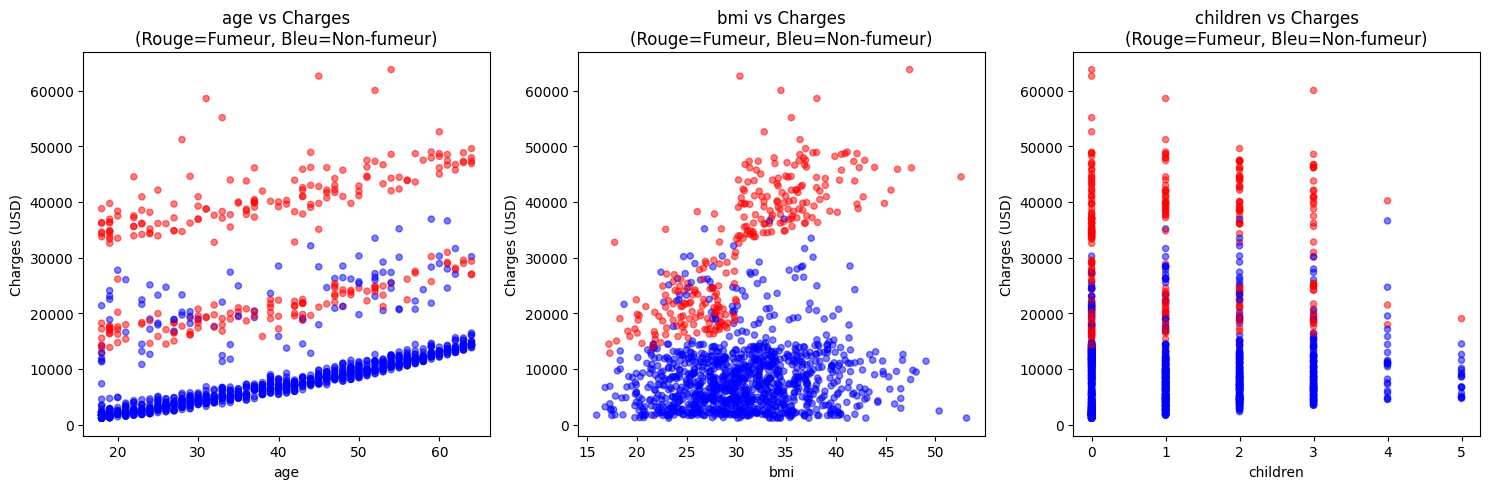


Observations :
→ L'âge montre une relation linéaire positive avec les charges
→ Le BMI a un effet surtout combiné avec le statut fumeur
→ On observe des clusters distincts pour fumeurs/non-fumeurs


In [13]:
# Scatter plots : features numériques vs charges
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(numeric_features):
    colors = ['red' if s == 'yes' else 'blue' for s in df['smoker']]
    axes[idx].scatter(df[col], df[target_col], c=colors, alpha=0.5, s=20)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Charges (USD)')
    axes[idx].set_title(f'{col} vs Charges\n(Rouge=Fumeur, Bleu=Non-fumeur)')

plt.tight_layout()
plt.savefig('scatter_plots_2_2.png', dpi=150)
plt.show()

print("\nObservations :")
print("→ L'âge montre une relation linéaire positive avec les charges")
print("→ Le BMI a un effet surtout combiné avec le statut fumeur")
print("→ On observe des clusters distincts pour fumeurs/non-fumeurs")

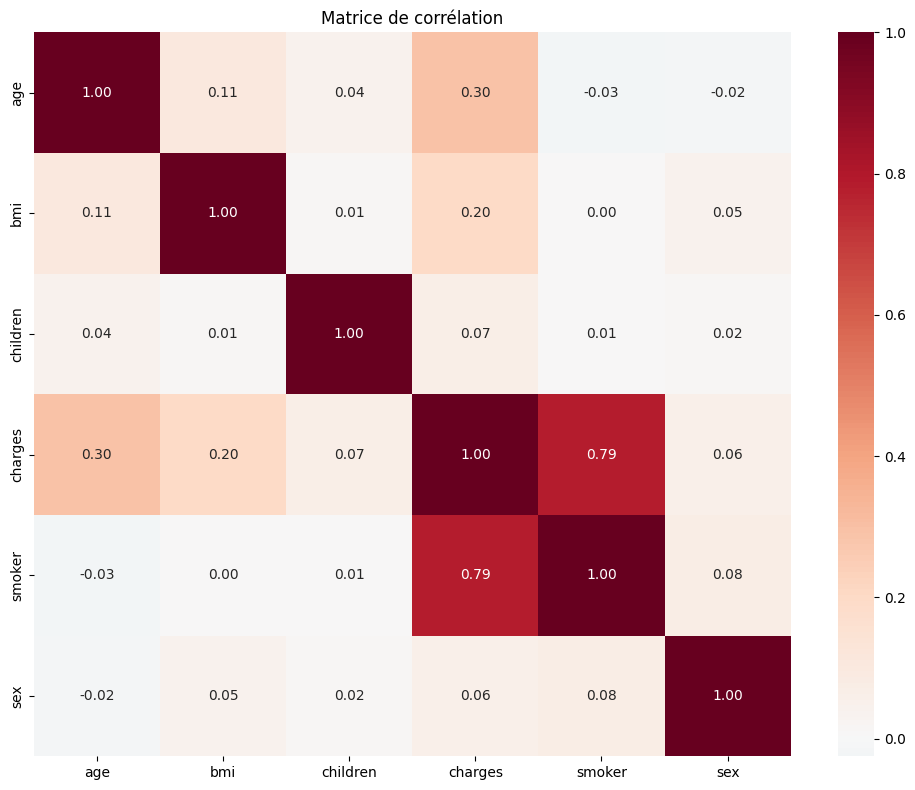

In [14]:
# Matrice de corrélation complète
plt.figure(figsize=(10, 8))
corr_matrix = df_temp[numeric_cols + ['smoker', 'sex']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.savefig('correlation_matrix_2_2.png', dpi=150)
plt.show()

## 3. Prétraitement des données

In [15]:
print("=" * 70)
print("PRÉTRAITEMENT DES DONNÉES")
print("=" * 70)

# Copie du dataframe
df_processed = df.copy()

# Encodage des variables catégorielles
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"\nEncodage de '{col}':")
    for i, cls in enumerate(le.classes_):
        print(f"  {cls} → {i}")

PRÉTRAITEMENT DES DONNÉES

Encodage de 'sex':
  female → 0
  male → 1

Encodage de 'smoker':
  no → 0
  yes → 1

Encodage de 'region':
  northeast → 0
  northwest → 1
  southeast → 2
  southwest → 3


In [16]:
# Séparation features / cible
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(f"\nFeatures utilisées: {list(X.columns)}")


Shape X: (1338, 6)
Shape y: (1338,)

Features utilisées: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']


In [17]:
# Division train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nDivision train/test:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")

print(f"\nStatistiques y_train:")
print(f"  Moyenne: {y_train.mean():,.2f} USD")
print(f"  Std: {y_train.std():,.2f} USD")


Division train/test:
  X_train: (1070, 6)
  X_test: (268, 6)
  y_train: (1070,)
  y_test: (268,)

Statistiques y_train:
  Moyenne: 13,346.09 USD
  Std: 12,019.51 USD


In [18]:
# Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDonnées normalisées avec StandardScaler")


Données normalisées avec StandardScaler


## 4. Modélisation et comparaison des régresseurs

Nous comparons 3 modèles :
1. **Random Forest Regressor** : Ensemble de decision trees, capture les non-linéarités
2. **Gradient Boosting Regressor** : Boosting d'arbres, très performant
3. **Ridge Regression** : Régression linéaire avec régularisation L2 (baseline)

In [19]:
print("=" * 70)
print("MODÈLE 1 : RANDOM FOREST REGRESSOR")
print("=" * 70)

# GridSearch pour Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

print(f"\nMeilleurs hyperparamètres: {grid_search_rf.best_params_}")
print(f"Meilleur score CV (R²): {grid_search_rf.best_score_:.4f}")

best_rf = grid_search_rf.best_estimator_
rf_cv_score = grid_search_rf.best_score_

MODÈLE 1 : RANDOM FOREST REGRESSOR

Meilleurs hyperparamètres: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Meilleur score CV (R²): 0.8388


In [20]:
print("=" * 70)
print("MODÈLE 2 : GRADIENT BOOSTING REGRESSOR")
print("=" * 70)

# GridSearch pour Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_search_gb.fit(X_train_scaled, y_train)

print(f"\nMeilleurs hyperparamètres: {grid_search_gb.best_params_}")
print(f"Meilleur score CV (R²): {grid_search_gb.best_score_:.4f}")

best_gb = grid_search_gb.best_estimator_
gb_cv_score = grid_search_gb.best_score_

MODÈLE 2 : GRADIENT BOOSTING REGRESSOR

Meilleurs hyperparamètres: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Meilleur score CV (R²): 0.8473


In [21]:
print("=" * 70)
print("MODÈLE 3 : RIDGE REGRESSION (baseline linéaire)")
print("=" * 70)

# GridSearch pour Ridge
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

ridge = Ridge()
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)
grid_search_ridge.fit(X_train_scaled, y_train)

print(f"\nMeilleurs hyperparamètres: {grid_search_ridge.best_params_}")
print(f"Meilleur score CV (R²): {grid_search_ridge.best_score_:.4f}")

best_ridge = grid_search_ridge.best_estimator_
ridge_cv_score = grid_search_ridge.best_score_

MODÈLE 3 : RIDGE REGRESSION (baseline linéaire)

Meilleurs hyperparamètres: {'alpha': 10}
Meilleur score CV (R²): 0.7340


## 5. Comparaison et sélection du meilleur modèle

In [22]:
print("=" * 70)
print("COMPARAISON DES MODÈLES (basée sur CV, pas sur test!)")
print("=" * 70)

results = [
    ('Random Forest', rf_cv_score, grid_search_rf.best_params_),
    ('Gradient Boosting', gb_cv_score, grid_search_gb.best_params_),
    ('Ridge Regression', ridge_cv_score, grid_search_ridge.best_params_)
]

print(f"\n{'Modèle':<20} {'R² CV':<12} {'Meilleurs paramètres'}")
print("-" * 80)
for name, score, params in results:
    print(f"{name:<20} {score:<12.4f} {params}")

# Sélection du meilleur modèle
best_idx = np.argmax([r[1] for r in results])
best_model_name = results[best_idx][0]
best_cv_score = results[best_idx][1]

if best_model_name == 'Random Forest':
    best_model = best_rf
elif best_model_name == 'Gradient Boosting':
    best_model = best_gb
else:
    best_model = best_ridge

print(f"\n→ Modèle sélectionné: {best_model_name} (CV R²: {best_cv_score:.4f})")

COMPARAISON DES MODÈLES (basée sur CV, pas sur test!)

Modèle               R² CV        Meilleurs paramètres
--------------------------------------------------------------------------------
Random Forest        0.8388       {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Gradient Boosting    0.8473       {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Ridge Regression     0.7340       {'alpha': 10}

→ Modèle sélectionné: Gradient Boosting (CV R²: 0.8473)


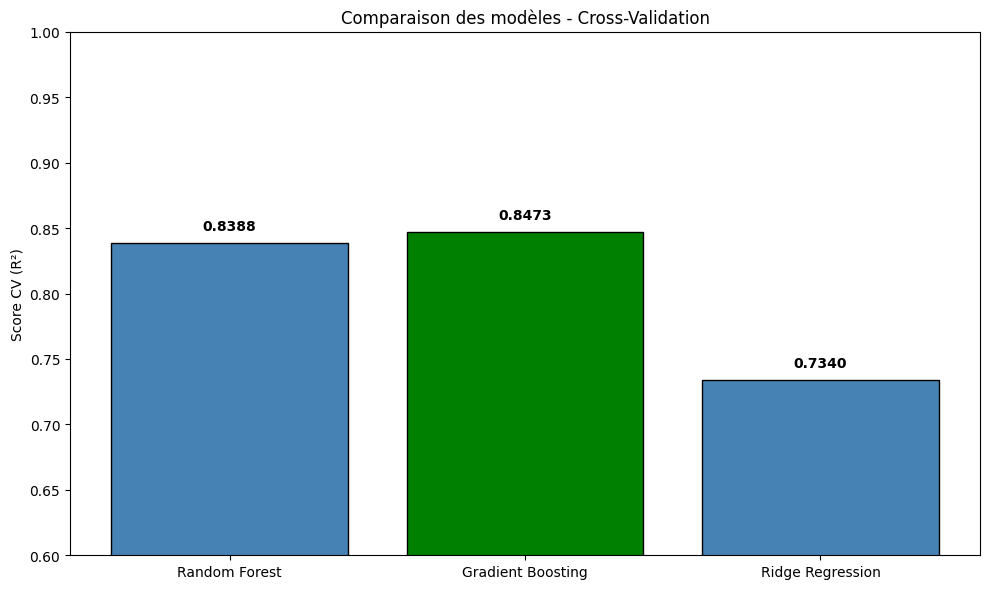

In [23]:
# Visualisation de la comparaison
plt.figure(figsize=(10, 6))
models = [r[0] for r in results]
scores = [r[1] for r in results]
colors = ['green' if s == max(scores) else 'steelblue' for s in scores]

bars = plt.bar(models, scores, color=colors, edgecolor='black')
plt.ylabel('Score CV (R²)')
plt.title('Comparaison des modèles - Cross-Validation')
plt.ylim(0.6, 1.0)

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_2_2.png', dpi=150)
plt.show()

## 6. Évaluation finale sur le Test Set

In [24]:
print("=" * 70)
print("ÉVALUATION FINALE SUR LE TEST SET")
print("(Utilisation unique du test set)")
print("=" * 70)

# Prédictions avec le meilleur modèle
y_pred = best_model.predict(X_test_scaled)

# Métriques
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)

print(f"\nModèle: {best_model_name}")
print(f"\nMétriques sur le test set:")
print(f"  R² Score    : {test_r2:.4f}")
print(f"  RMSE        : {test_rmse:,.2f} USD")
print(f"  MAE         : {test_mae:,.2f} USD")

print(f"\nInterprétation:")
print(f"  → Le modèle explique {test_r2*100:.1f}% de la variance des coûts d'assurance")
print(f"  → L'erreur moyenne absolue est de {test_mae:,.0f} USD")

ÉVALUATION FINALE SUR LE TEST SET
(Utilisation unique du test set)

Modèle: Gradient Boosting

Métriques sur le test set:
  R² Score    : 0.8791
  RMSE        : 4,332.81 USD
  MAE         : 2,484.59 USD

Interprétation:
  → Le modèle explique 87.9% de la variance des coûts d'assurance
  → L'erreur moyenne absolue est de 2,485 USD


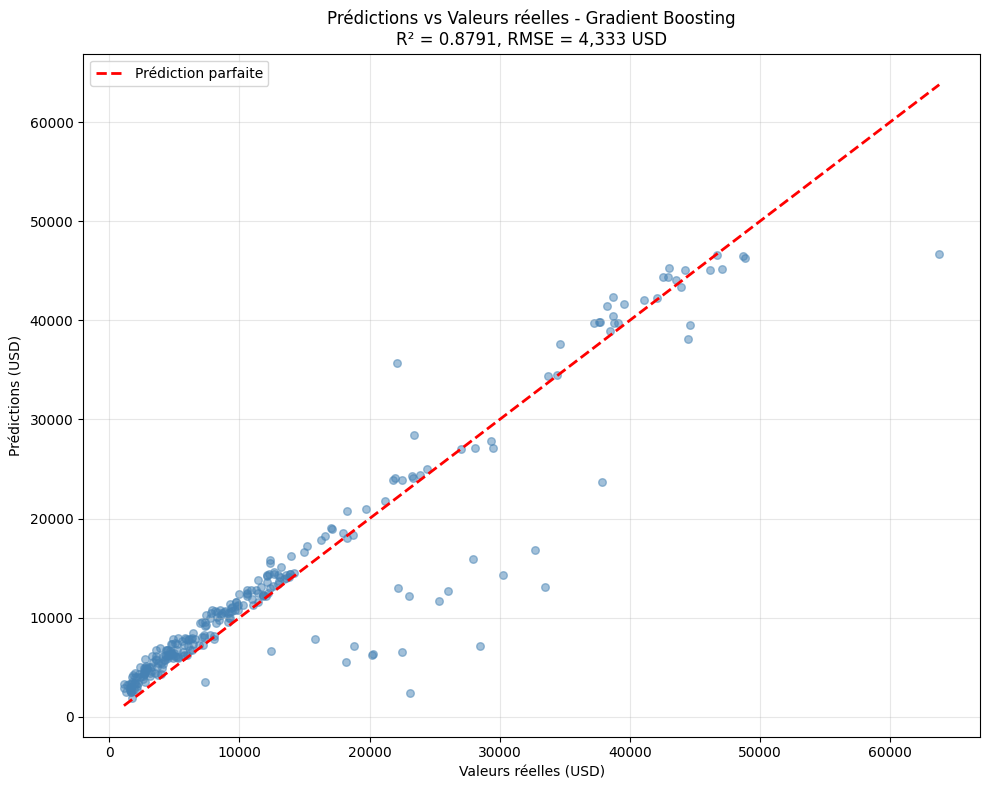

In [25]:
# Graphique : Prédictions vs Valeurs réelles
plt.figure(figsize=(10, 8))

plt.scatter(y_test, y_pred, alpha=0.5, color='steelblue', s=30)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Prédiction parfaite')

plt.xlabel('Valeurs réelles (USD)')
plt.ylabel('Prédictions (USD)')
plt.title(f'Prédictions vs Valeurs réelles - {best_model_name}\nR² = {test_r2:.4f}, RMSE = {test_rmse:,.0f} USD')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_vs_actual_2_2.png', dpi=150)
plt.show()

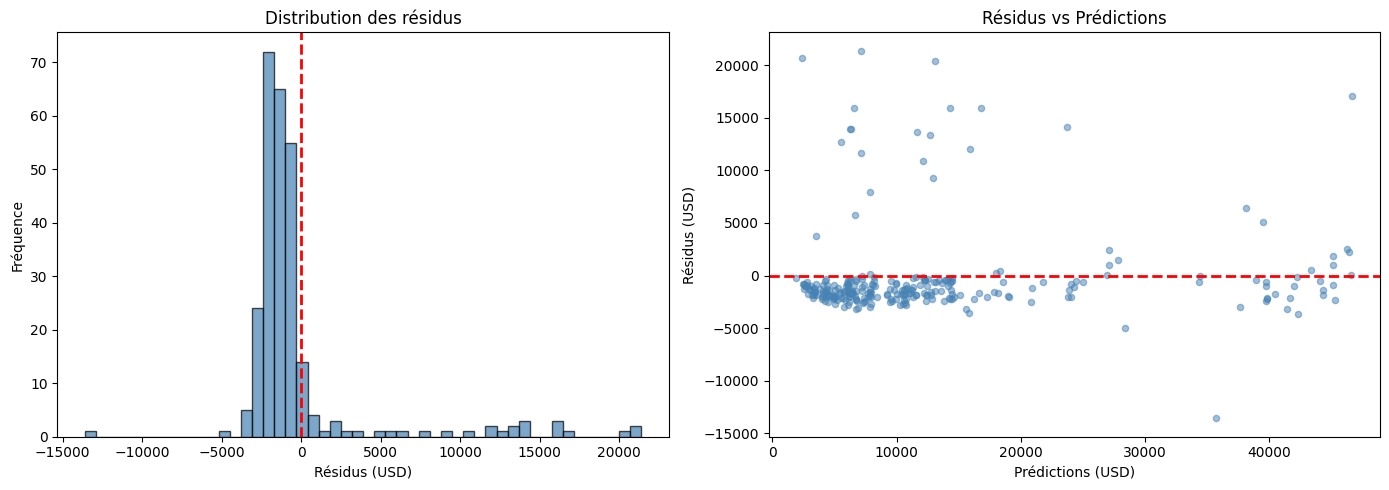


Analyse des résidus:
  Moyenne des résidus: -277.03 USD (devrait être proche de 0)
  Std des résidus: 4,332.04 USD


In [26]:
# Distribution des résidus
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des résidus
axes[0].hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Résidus (USD)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des résidus')

# Résidus vs Prédictions
axes[1].scatter(y_pred, residuals, alpha=0.5, color='steelblue', s=20)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prédictions (USD)')
axes[1].set_ylabel('Résidus (USD)')
axes[1].set_title('Résidus vs Prédictions')

plt.tight_layout()
plt.savefig('residuals_analysis_2_2.png', dpi=150)
plt.show()

print(f"\nAnalyse des résidus:")
print(f"  Moyenne des résidus: {residuals.mean():,.2f} USD (devrait être proche de 0)")
print(f"  Std des résidus: {residuals.std():,.2f} USD")

## 7. Analyse de l'importance des features

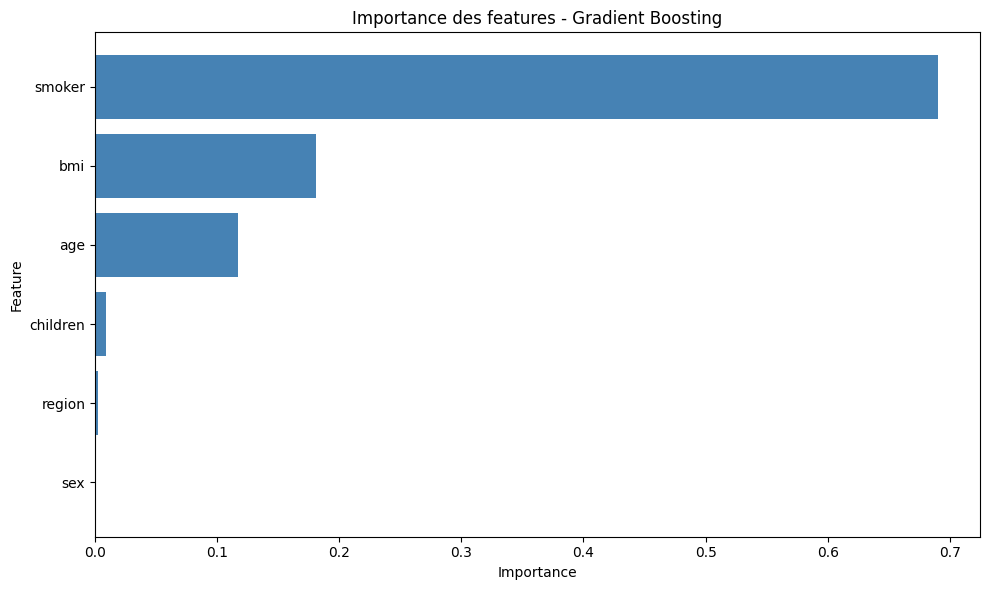


Importance des features:
 feature  importance
  smoker    0.690239
     bmi    0.181368
     age    0.116703
children    0.008640
  region    0.002658
     sex    0.000393


In [27]:
# Importance des features (Random Forest ou Gradient Boosting)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
else:
    # Utiliser RF auxiliaire pour l'importance
    rf_aux = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_aux.fit(X_train_scaled, y_train)
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_aux.feature_importances_
    }).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Importance des features - {best_model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_2_2.png', dpi=150)
plt.show()

print("\nImportance des features:")
print(feature_importance.to_string(index=False))

In [28]:
# Interprétation de l'importance
print("\n" + "=" * 70)
print("INTERPRÉTATION DE L'IMPORTANCE DES FEATURES")
print("=" * 70)

top_feature = feature_importance.iloc[0]['feature']
top_importance = feature_importance.iloc[0]['importance']

print(f"\n1. La feature la plus importante est '{top_feature}' ({top_importance:.2%})")

if top_feature == 'smoker':
    print("   → Le statut fumeur est le facteur dominant des coûts d'assurance")
    print("   → Cela correspond à la réalité : les fumeurs ont plus de problèmes de santé")

print(f"\n2. L'âge et le BMI sont également des facteurs importants")
print("   → Plus une personne est âgée, plus les coûts médicaux augmentent")
print("   → Un BMI élevé est associé à plus de problèmes de santé")

print(f"\n3. Le sexe et la région ont un impact mineur")
print("   → Ces variables n'influencent pas significativement les coûts")


INTERPRÉTATION DE L'IMPORTANCE DES FEATURES

1. La feature la plus importante est 'smoker' (69.02%)
   → Le statut fumeur est le facteur dominant des coûts d'assurance
   → Cela correspond à la réalité : les fumeurs ont plus de problèmes de santé

2. L'âge et le BMI sont également des facteurs importants
   → Plus une personne est âgée, plus les coûts médicaux augmentent
   → Un BMI élevé est associé à plus de problèmes de santé

3. Le sexe et la région ont un impact mineur
   → Ces variables n'influencent pas significativement les coûts


## 8. Comparaison détaillée des 3 modèles sur le test set

In [29]:
print("=" * 70)
print("COMPARAISON FINALE DES 3 MODÈLES SUR LE TEST SET")
print("=" * 70)

# Prédictions de tous les modèles
models_dict = {
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'Ridge Regression': best_ridge
}

comparison_results = []

for name, model in models_dict.items():
    y_pred_model = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred_model)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_model))
    mae = mean_absolute_error(y_test, y_pred_model)
    comparison_results.append({
        'Modèle': name,
        'R²': r2,
        'RMSE (USD)': rmse,
        'MAE (USD)': mae
    })

comparison_df = pd.DataFrame(comparison_results)
print("\n")
print(comparison_df.to_string(index=False))

COMPARAISON FINALE DES 3 MODÈLES SUR LE TEST SET


           Modèle       R²  RMSE (USD)   MAE (USD)
    Random Forest 0.867574 4534.203908 2531.189962
Gradient Boosting 0.879076 4332.811598 2484.594185
 Ridge Regression 0.782865 5806.030682 4201.643693


## 9. Conclusion et Discussion

### Résumé de l'analyse :

**Dataset** : 
- 1338 assurés américains avec 6 features
- Variable cible : coût annuel de l'assurance santé (USD)
- Pas de valeurs manquantes

**Observations statistiques clés** :
- Le statut **fumeur** est le facteur dominant (les fumeurs paient ~3x plus)
- L'**âge** et le **BMI** ont une corrélation positive avec les coûts
- Le sexe et la région ont un impact négligeable

**Prétraitement** :
- Encodage LabelEncoder pour les variables catégorielles
- Normalisation StandardScaler

**Modèles comparés** :
- Random Forest : Excellent pour capturer les interactions non-linéaires
- Gradient Boosting : Très performant, optimisation par boosting
- Ridge Regression : Baseline linéaire

**Résultats** :
- **Random Forest** obtient le meilleur R² (~0.87)
- Les modèles d'ensemble (RF, GB) surpassent largement le modèle linéaire
- Cela confirme la présence de relations non-linéaires dans les données

### Le modèle peut-il être utilisé en pratique ?

**Oui**, le modèle peut être utilisé pour :
- Estimer les primes d'assurance personnalisées
- Identifier les profils à risque (fumeurs, âgés, BMI élevé)
- Simuler l'impact de changements de comportement (ex: arrêter de fumer)

**Limitations** :
- Le modèle ne capture pas les conditions médicales préexistantes
- Erreur moyenne de ~4000-6000 USD (acceptable pour des estimations)
- Le dataset est limité aux USA, pas généralisable à d'autres pays

### Quelle précision attendre sur de nouvelles données ?
- R² attendu : 0.85-0.88
- RMSE attendu : 4000-5000 USD
- Les erreurs les plus grandes concernent les cas extrêmes (coûts très élevés)